In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_colwidth', 300)
from sklearn.metrics import (precision_score,recall_score,
                             f1_score, accuracy_score,confusion_matrix, classification_report)

In [2]:
colorcode=pd.read_csv('../data/processed/color_code.csv',index_col=0)
train=pd.read_csv('../data/train/train.csv',index_col=0)
test=pd.read_csv('../data/test/test.csv',index_col=0)

In [3]:
X_train=train[['ABV','IBU','Color']]
X_test=test[['ABV','IBU','Color']]

y_train=train['Style_color']
y_test=test['Style_color']

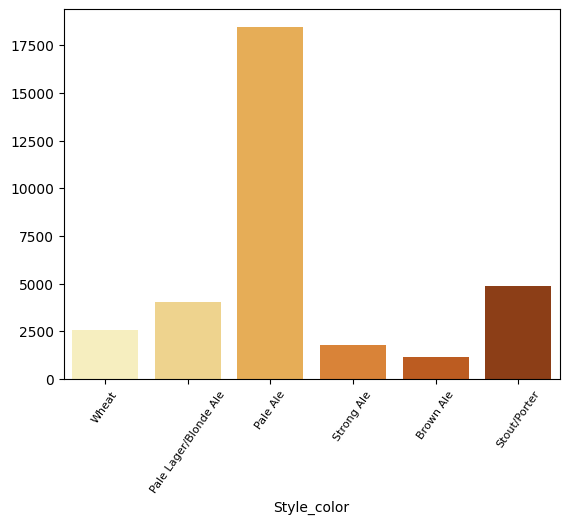

In [16]:
traincounts=y_train.value_counts()
sns.barplot(x=traincounts.index, y=traincounts.values, palette="YlOrBr")
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);

In [4]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [18]:
y_resampled.value_counts()

Style_color
0    1136
1    1136
2    1136
3    1136
4    1136
5    1136
Name: count, dtype: int64

In [74]:
from sklearn.compose import ColumnTransformer
col_toscale=['ABV', 'IBU', 'Color']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('scaler', MinMaxScaler(), col_toscale)],
#     remainder='passthrough')

In [5]:
pipeScale = Pipeline(steps=[
    # ('preprocessor',preprocessor),
    ("selectkbest", SelectKBest(k=3)),
    ("classifier", RandomForestClassifier())
])

In [6]:
log_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [LogisticRegression()],
    'classifier__C': [0.1,1,10]
}
rf_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [3,5,7]
}
gb_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [GradientBoostingClassifier()],
    'classifier__max_depth':[3,5,7]
}
knn_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': np.arange(1,10)
}
svm_params = {
    'selectkbest__k':np.arange(1,4),
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10]
}

search_space = [
    # {'preprocessor__scaler__feature_range': [(0, 1)]},   #remove for gs2
    log_params,
    rf_params,
    gb_params,
    knn_params,
    svm_params   
]

In [7]:

scoring={'f1_weighted': 'f1_weighted',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted'}
clf_gs = GridSearchCV(estimator=pipeScale, param_grid=search_space, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [78]:
clf_gs.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         ['ABV',
                                                                          'IBU',
                                                                          'Color'])])),
                                       ('selectkbest', SelectKBest(k=3)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'preprocessor__scaler__feature_range': [(0, 1)]},
                         {'classifier': [Log...
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])}],
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted',
                      'precision_weighted': 'precision_weighted',
                      'recall_weighted': 'recall_weighted'},
             verbose=3)

In [79]:
print(clf_gs.best_estimator_)
print(clf_gs.best_score_)
print(clf_gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['ABV', 'IBU', 'Color'])])),
                ('selectkbest', SelectKBest(k=3)),
                ('classifier', GradientBoostingClassifier())])
0.8544279003315515
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 3, 'selectkbest__k': 3}


In [80]:
#Yet another pipeline with no scaling

In [85]:
pipeNoscale = Pipeline(steps=[
    ("selectkbest", SelectKBest(k=3)),
    ("classifier", RandomForestClassifier())
])
clf_gs2 = GridSearchCV(estimator=pipeNoscale, param_grid=search_space, cv=5, scoring=scoring, refit='f1_weighted',verbose=3, n_jobs=-1,error_score='raise')

In [86]:
clf_gs2.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('selectkbest', SelectKBest(k=3)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_depth': [3, 5, 7],
                          'selectkbest__k': ar...
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'selectkbest__k': array([1, 2, 3])},
                         {'classifier': [SVC()], 'classifier__C': [0.1, 1, 10],
                          'selectkbest__k': array([1, 2, 3])}],
             refit='f1_weighted',
             scoring={'f1_weighted': 'f1_weighted',
                      'precision_weighted': 'precision_weighted',
                      'recall_weighted': 'recall_weighted'},
             verbose=3)

In [122]:
print(clf_gs2.best_estimator_)
print(clf_gs2.best_score_)
print(clf_gs2.best_params_)

Pipeline(steps=[('selectkbest', SelectKBest(k=3)),
                ('classifier', GradientBoostingClassifier())])
0.854421245424781
{'classifier': GradientBoostingClassifier(), 'classifier__max_depth': 3, 'selectkbest__k': 3}


Let's do some predictions and evaluate our model.

In [91]:
# scaled_GBC=clf_gs.best_estimator_
GBC2=clf_gs2.best_estimator_

In [ ]:
# feature_importances = GBC2.feature_importances_

In [116]:
gbc_noscale=GBC2.fit(X_resampled,y_resampled)

In [117]:
# y_predScale = clf_gs.best_estimator_.predict(X_test)
y_pred2 = GBC2.predict(X_test)

In [118]:
predicions_proba = GBC2.predict_proba(X_test)
# predicions_proba

In [127]:

print('accuracy_score',accuracy_score(y_pred2,y_test))
print('precision_score',precision_score(y_pred2,y_test, average='weighted'))
print('f1_score',f1_score(y_pred2,y_test, average='weighted'))
print('recall_score',recall_score(y_pred2,y_test, average='weighted'))
# print(classification_report(yc_test, predictions))

accuracy_score 0.9115714546450082
precision_score 0.9107736494345775
f1_score 0.9085600669768499
recall_score 0.9115714546450082


In [110]:
cm = confusion_matrix(y_test, y_pred2,normalize='true')
# print(cm)

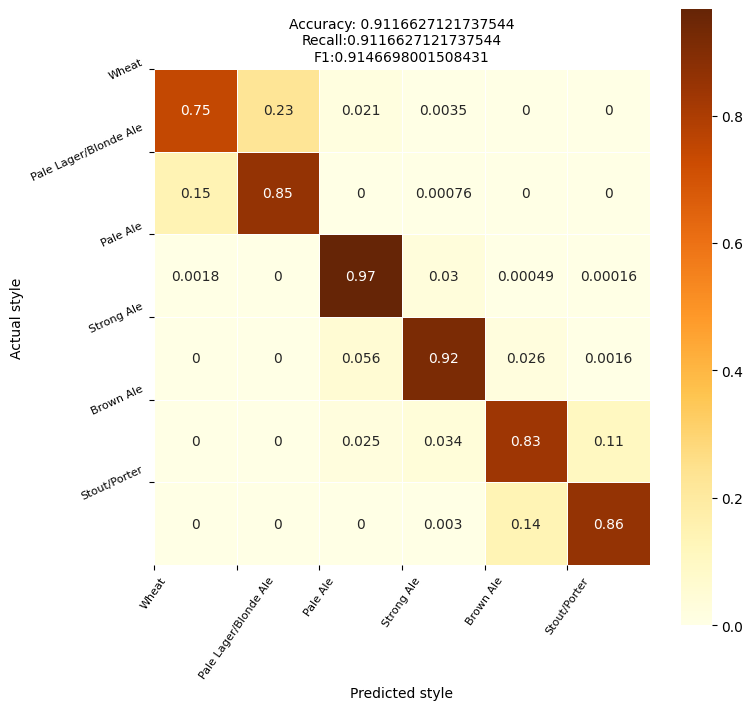

In [111]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, linewidths=.5, square = True, cmap = 'YlOrBr')
plt.ylabel('Actual style')
plt.xlabel('Predicted style')
all_sample_title = (f'Accuracy: {accuracy_score(y_test, y_pred2)}\nRecall:{recall_score(y_test, y_pred2, average="weighted")}\nF1:{f1_score(y_test, y_pred2, average="weighted")}')
plt.title(all_sample_title, size = 10);
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);
plt.yticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'],rotation=25,fontsize=8);

In [13]:
testcounts=y_test.value_counts()

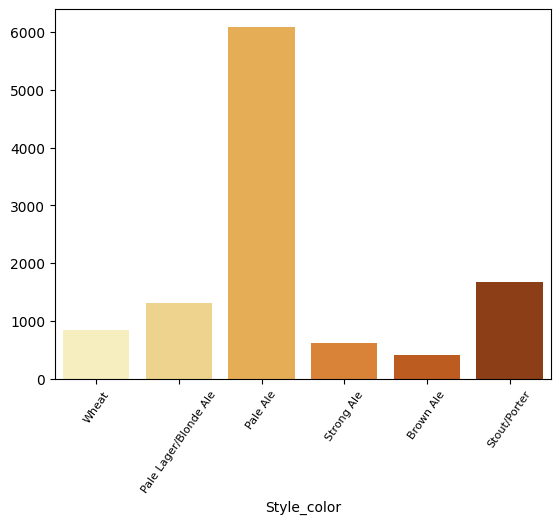

In [15]:
sns.barplot(x=testcounts.index, y=testcounts.values, palette="YlOrBr")
plt.xticks(ticks=range(len(colorcode.index)), labels=colorcode['Style'], rotation=55,fontsize=8);

In [121]:
import pickle
# with open('../models/gbc_noscaling.pkl', 'wb') as output:
#     pickle.dump(gbc_noscale, output)

# with open('../models/lr1', 'rb') as input:
#     modelo_importado = pickle.load(input) 